In [ ]:
from numpy.random import seed
# seed(101)
# from tensorflow import set_random_seed
# set_random_seed(101)
import tensorflow
tensorflow.random.set_seed(101)

import pandas as pd
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir')


['train_dir', 'val_dir']

In [ ]:
df_data = pd.read_csv('drive/MyDrive/datasets/MPR/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
#X = df_data.drop('dx', axis=1)
y = df_data['dx']

df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(9013, 7)
(1002, 7)


In [ ]:
df_train['dx'].value_counts()


dx
nv       6034
mel      1002
bkl       989
bcc       463
akiec     294
vasc      128
df        103
Name: count, dtype: int64

In [ ]:
df_val['dx'].value_counts()


dx
nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: count, dtype: int64

In [ ]:
df_data.set_index('image_id', inplace=True)


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/train_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/train_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/train_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/train_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/train_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/train_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/train_dir/df')))


6065
1011
1275
1176
1229
1074
884


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/val_dir/nv')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/val_dir/mel')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/val_dir/bkl')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/val_dir/bcc')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/val_dir/akiec')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/val_dir/vasc')))
print(len(os.listdir('/content/drive/MyDrive/datasets/MPR/base_dir/val_dir/df')))


671
111
110
51
33
14
12


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
IMAGE_SIZE = [170, 170]

In [ ]:
train_path = '/content/drive/MyDrive/datasets/MPR/base_dir/train_dir'
valid_path = '/content/drive/MyDrive/datasets/MPR/base_dir/val_dir'

In [ ]:
# Load pre-trained ResNet50 model
base_model = ResNet50(input_shape=(170, 170, 3), weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze initial layers and fine-tune later layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
import os
from glob import glob

folders = glob('/content/drive/MyDrive/datasets/MPR/base_dir/train_dir/*')
class_names = []

# Extract bird names from folder paths
for folder in folders:
    class_name = os.path.basename(folder)
    class_names.append(class_name)

print(class_names)


['mel', 'akiec', 'df', 'bkl', 'vasc', 'bcc', 'nv']


In [ ]:
# Add custom layers on top of ResNet50
x = Flatten()(base_model.output)
x = Dropout(0.5)(x)  # Adding dropout for regularization
prediction = Dense(len(class_names), activation='softmax')(x)


In [ ]:
# Create model
model = Model(inputs=base_model.input, outputs=prediction)


In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.001)  # Experiment with different learning rates
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the directory containing the selected images for training
train_dir = '/content/drive/MyDrive/datasets/MPR/base_dir/train_dir'

# Path to the directory containing the validation images
val_dir = '/content/drive/MyDrive/datasets/MPR/base_dir/val_dir'

# Setup data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data for training
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(170, 170),
    batch_size=32,
    class_mode='categorical'
)

# Generate batches of data for validation
val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(170, 170),
    batch_size=32,
    class_mode='categorical'
)


Found 12714 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Train the model
r = model.fit(
    training_set,
    validation_data=val_set,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
398/398 [==============================] - 3586s 9s/step - loss: 2.0704 - accuracy: 0.4201 - val_loss: 1.0594 - val_accuracy: 0.6747
Epoch 2/10
398/398 [==============================] - 239s 599ms/step - loss: 1.6204 - accuracy: 0.4703 - val_loss: 1.1354 - val_accuracy: 0.6627
Epoch 3/10
398/398 [==============================] - 238s 597ms/step - loss: 1.5759 - accuracy: 0.4775 - val_loss: 1.1911 - val_accuracy: 0.6487
Epoch 4/10
398/398 [==============================] - 237s 596ms/step - loss: 1.5325 - accuracy: 0.4882 - val_loss: 1.2241 - val_accuracy: 0.6248


In [ ]:
model.save('drive/MyDrive/densent_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Get the final training accuracy
train_accuracy = r.history['accuracy'][-1]

# Get the final validation accuracy
val_accuracy = r.history['val_accuracy'][-1]

# Convert accuracy to percentage
train_accuracy_percent = train_accuracy * 100
val_accuracy_percent = val_accuracy * 100

# Display the accuracy
print(f"Training Accuracy: {train_accuracy_percent:.2f}%")
print(f"Validation Accuracy: {val_accuracy_percent:.2f}%")


Training Accuracy: 48.82%
Validation Accuracy: 62.48%


32/32 [==============================] - 14s 417ms/step


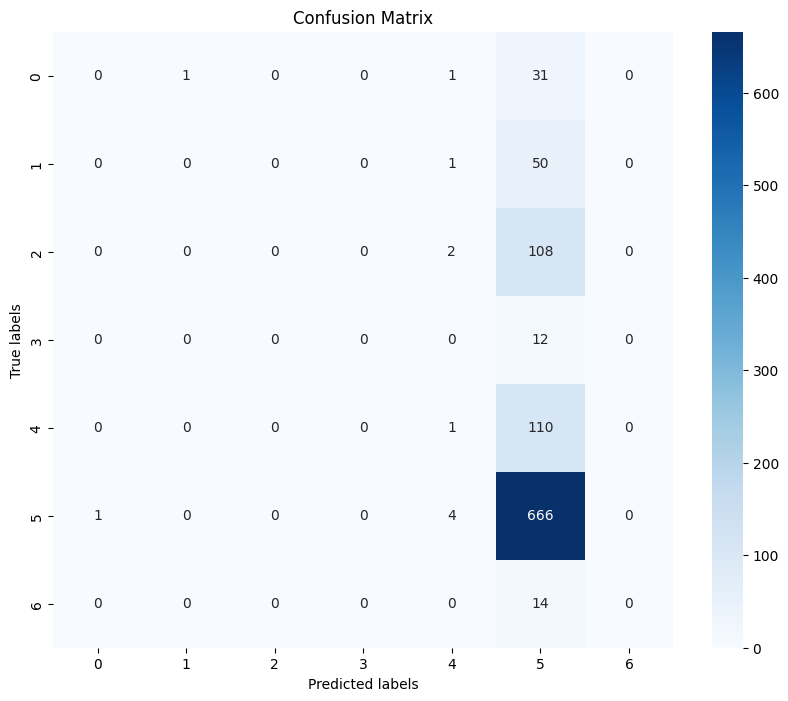

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have trained your model and obtained predictions and ground truth labels
predictions = model.predict(val_set)
y_pred = np.argmax(predictions, axis=1)
y_true = val_set.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



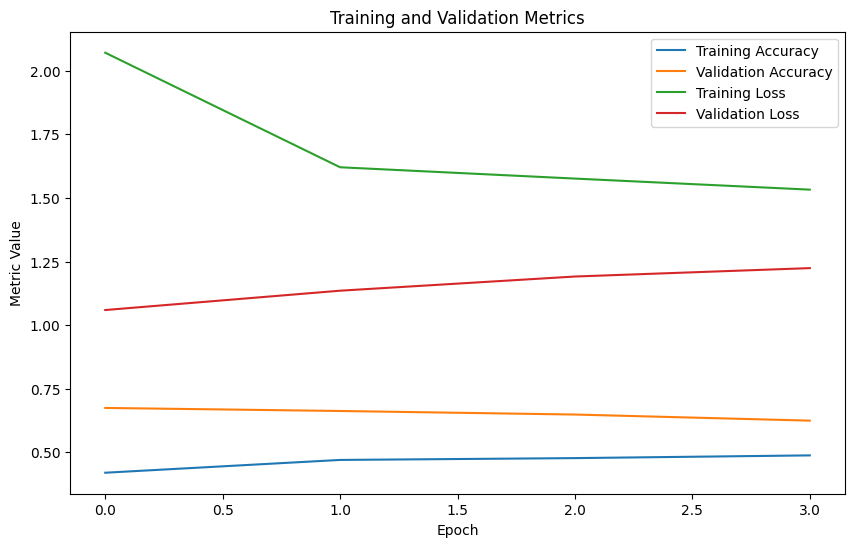

In [ ]:
# Test Accuracy and Loss Graph
plt.figure(figsize=(10, 6))
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Print precision, recall, and F1-score
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')


Precision: 0.46
Recall: 0.67
F1-score: 0.54


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
